# Import Dependencies

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

# Data Preperation

### Load Dataset

In [3]:
# Import dataset
dataset = pd.read_csv("train.csv")

### Visualize Dataset

In [4]:
import matplotlib.pyplot as plt

def print_rand(data:pd.core.frame.DataFrame , number_of_sample:int):
    for i in range(number_of_sample):
        n = np.random.randint(0,high=len(data))
        print('MNIST database example digit: ', data['label'][n])
        im = data.drop(['label'], axis=1).iloc[n].to_numpy()
        plt.imshow(im.reshape(28,28))
        plt.show()

In [5]:
print(dataset.shape)
print(len(dataset))

(42000, 785)
42000


MNIST database example digit:  7


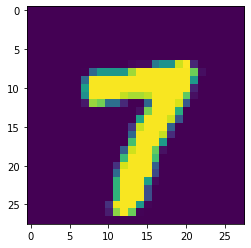

MNIST database example digit:  1


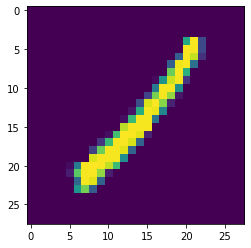

MNIST database example digit:  7


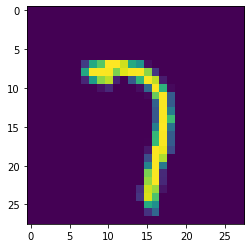

In [6]:
print_rand(dataset,3)

### Preprocess the dataset

In [7]:
from sklearn.model_selection import train_test_split

# divide preliminary dataset set into features and labels
X = dataset.drop(columns=["label"]) # features
y = dataset['label'] # labels

### Check Class distribution

{1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795}


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


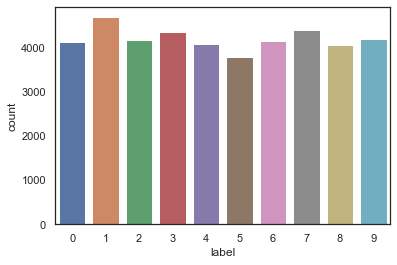

In [8]:
import seaborn as sns

sns.set(style='white', context='notebook', palette='deep')
# check whether class distribution is inbalanced in order to decide whether to use k-fold or stratified
print(dict(y.value_counts()))
g = sns.countplot(y)

### Check for null and missing values

In [9]:
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [10]:
y.isnull().any()

False

### From Grayscale to RGB

In [11]:
dataset.shape

(42000, 785)

In [26]:
def grey_to_RGB(data:pd.core.frame.DataFrame, IMG_RES:int):
    dim = np.zeros((IMG_RES,IMG_RES)) # Dimension Array
    X_RGB = [] # Empty list to save RGB images 
    X_temp = data.drop(columns=["label"])
    for i in range(X.shape[0]):
        im = X_temp.iloc[i].to_numpy() # fetch image
        im = im.reshape(IMG_RES,IMG_RES) # Reshape the image
        R = np.stack((im,dim,dim),axis=2) # Add Red Dimension
        G = np.stack((dim,im,dim),axis=2) # Add Green Dimension
        B = np.stack((dim,dim,im),axis=2) # Add Blue Dimension
        X_RGB.append(R+G+B)
        print("DONE")
    return X_RGB # Returns the List of Images

In [27]:
deneme = grey_to_RGB(dataset,28)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


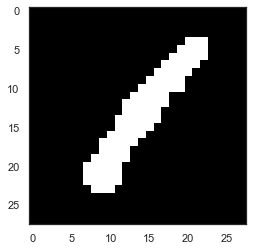

In [34]:
plt.imshow(deneme[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


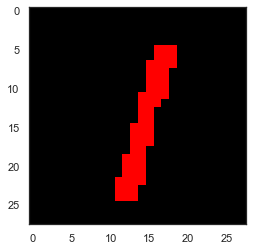

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


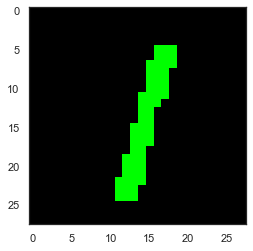

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


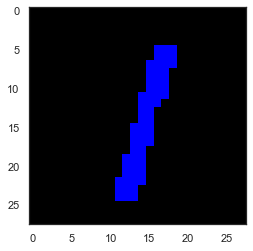

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(28, 28, 3)
<class 'numpy.ndarray'>


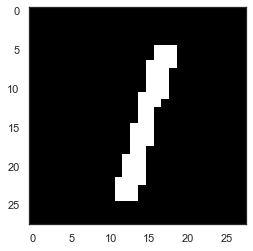

In [61]:
im = dataset.drop(['label'], axis=1).iloc[15].to_numpy()
dim = np.zeros((28,28))
im = im.reshape(28,28)

R = np.stack((im,dim,dim),axis=2)
plt.imshow(R)
plt.show()
G = np.stack((dim,im,dim),axis=2)
plt.imshow(G)
plt.show()
B = np.stack((dim,dim,im),axis=2)
plt.imshow(B)
plt.show()
print(R.shape)
G = R+G+B
print(type(G))
plt.imshow(R+G+B)
plt.show()

### Reshape the Dataset

In [ ]:
IMAGE_RES = 28
# Reshape and normalize the dataset
X = X.values.reshape(-1,28,28,1)/255.

In [ ]:
# split the dataset into Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, stratify=y) # 80 to 20% randomly

In [ ]:
# Split the train and the validation set for the fitting
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=112) # 90 to 10%

# Modelling

### Import the Pre-Trained Model

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))
# Freeze the Model
feature_extractor.trainable = False

### Setup the Layers

In [ ]:
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

### Set the model parameters

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ReduceLROnPlateau

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
from math import ceil

EPOCHS = 20 
BATCH_SIZE = 100
steps_per_epoch = ceil(X_train.shape[0]/BATCH_SIZE)

### Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

### Train the model

In [ ]:
from math import ceil
history = model.fit(X_train, y_train, epochs=EPOCHS, 
          #steps_per_epoch=ceil(X_train.shape[0]//BATCH_SIZE),
          steps_per_epoch=steps_per_epoch,
          verbose=2, callbacks=[learning_rate_reduction],
          validation_data = (X_val,y_val))

Epoch 1/20
351/351 - 11s - loss: 0.2438 - accuracy: 0.9263 - val_loss: 0.0923 - val_accuracy: 0.9714 - lr: 0.0010 - 11s/epoch - 33ms/step
Epoch 2/20
351/351 - 12s - loss: 0.0613 - accuracy: 0.9809 - val_loss: 0.0664 - val_accuracy: 0.9795 - lr: 0.0010 - 12s/epoch - 34ms/step
Epoch 3/20
351/351 - 13s - loss: 0.0435 - accuracy: 0.9865 - val_loss: 0.0538 - val_accuracy: 0.9836 - lr: 0.0010 - 13s/epoch - 36ms/step
Epoch 4/20
351/351 - 12s - loss: 0.0313 - accuracy: 0.9903 - val_loss: 0.0532 - val_accuracy: 0.9854 - lr: 0.0010 - 12s/epoch - 34ms/step
Epoch 5/20
351/351 - 12s - loss: 0.0229 - accuracy: 0.9927 - val_loss: 0.0521 - val_accuracy: 0.9854 - lr: 0.0010 - 12s/epoch - 34ms/step
Epoch 6/20
351/351 - 12s - loss: 0.0177 - accuracy: 0.9945 - val_loss: 0.0475 - val_accuracy: 0.9866 - lr: 0.0010 - 12s/epoch - 34ms/step
Epoch 7/20
351/351 - 12s - loss: 0.0120 - accuracy: 0.9966 - val_loss: 0.0578 - val_accuracy: 0.9845 - lr: 0.0010 - 12s/epoch - 34ms/step
Epoch 8/20
351/351 - 12s - loss: 0

### Evaluate the model

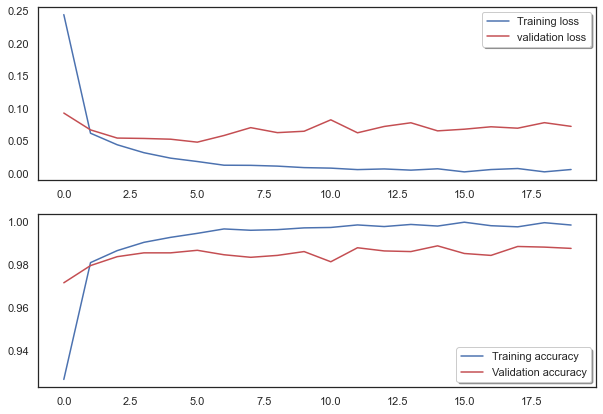

In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,7))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
results = model.predict(X_test)

print(results.shape)

print(results[-1].argmax())
print(type(results[-1].argmax()))

print(y_test.shape[0])
print(y_test.iloc[-1])
print(type(y_test.iloc[-1]))
print(type(y_test))

263/263 [==============================] - 1s 5ms/step
(8400, 10)
1
<class 'numpy.int64'>
8400
1
<class 'numpy.int64'>
<class 'pandas.core.series.Series'>


### Predict the results

In [ ]:
y_predict = model.predict(X_test)

263/263 [==============================] - 1s 5ms/step


### Evaluate the test accuracy

In [ ]:
def acc_model(y_test, y_predict):
    if y_test.shape[0] != y_predict.shape[0]:
        print("Invalid Input, size of the arrays do not match!")
        return 0
    else:
        sum=0
        for i in range(y_test.shape[0]):
            if y_test.iloc[i] == y_predict[i].argmax():
                sum += 1
    return float("%.4f" % (sum/y_test.shape[0]))

In [ ]:
accuracy = acc_model(y_test,y_predict)
accuracy

0.9885